In [26]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

from dataclasses import dataclass
from functools import partial

jax.devices()

jax.enable_checks = True

In [27]:
@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

In [3]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])

            
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3,4,5,6,7,8))
def trainingSet(n, m, T1 = 1.0, T2 = 2.0, K = 1.10, volMult = 1.5, anti=True, seed=2, bktVol=0.2):

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    bktVol = bktVol

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

    def func(X, inc1):
        print(X.shape, inc1.shape)
        S2 = X + inc1
        bkt2 = jnp.dot(S2, a)
        pay = jnp.maximum(0, bkt2 - K)

        # two antithetic paths
        # if anti:
        if False:
            
            S2a = X - inc1
            bkt2a = jnp.dot(S2a, a)
            paya = jnp.maximum(0, bkt2a - K)
            
            Y = 0.5 * (pay + paya)

            # # differentials
            # Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            # Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            # Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            Y = pay
            
            # # differentials
            # Z =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        return Y

    Y, Z = jax.vmap(jax.value_and_grad(func, argnums=0))(S1, inc1)
    ddYddX = jax.vmap(jax.hessian(func, argnums=0))(S1, inc1)
    
    X = S1
    return X, Y.reshape(-1,1), Z, ddYddX, a

# test set: returns an array of independent, uniformly random spots 
# with corresponding baskets, ground true prices, deltas and vegas
def testSet(n, a, T1 = 1.0, T2 = 2.0, K = 1.10, bktVol = 0.2, lower=0.5, upper=1.50, num=4096, seed=42):
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(num, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, a).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ a.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return spots, baskets, prices, deltas, vegas    

In [47]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])


@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    volMult: float = 1.5
    anti: bool = True
            
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2):
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult
    anti = params.anti

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    bktVol = bktVol

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

    def func(X, inc1):
        S2 = X + inc1
        bkt2 = jnp.dot(S2, a)
        pay = jnp.maximum(0, bkt2 - K)

        # two antithetic paths
        # if anti:
        if False:
            
            S2a = X - inc1
            bkt2a = jnp.dot(S2a, a)
            paya = jnp.maximum(0, bkt2a - K)
            
            Y = 0.5 * (pay + paya)
        # standard
        else:
            Y = pay

        return Y

    y, vjpfun = jax.vjp(func, S1, inc1)  # Compute the values and obtain a VJP function
    # basis = jnp.eye(y.size, dtype=y.dtype)
    # jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    jac = vjpfun(jnp.ones(y.size))[0]

    h = 1e-4
    fd_ph = func(S1 + h, inc1)
    fd_mh = func(S1 - h, inc1)
    fd = (fd_ph - fd_mh) / (2 * h)

    fdd = (fd_ph - 2 * y + fd_mh) / (h * h)

    # use finite differences to check:
    # h = 1e-4
    jac_fdd_ph = vjpfun(jnp.ones(y.size) + h)[0]
    jac_fdd_mh = vjpfun(jnp.ones(y.size) - h)[0]

    jac_fdd = (jac_fdd_ph - jac_fdd_mh) / (2 * h)

    print("jac is: ")
    print(jac.shape)

    print("y is: ")
    print(y.shape)
    print(y)
    if 0: 
        y, vjpfun = jax.vjp(func, S1, inc1)  # Compute the values and obtain a VJP function
        basis = jnp.eye(y.size, dtype=y.dtype)
        jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
        # return y, jac, vjpfun

        Y = y
        Z = jac

        Y, Z = jax.vmap(value_and_jacrev(func, argnums=0))(S1, inc1)

    Y, Z = jax.vmap(jax.value_and_grad(func, argnums=0))(S1, inc1)
    print("Y is: ")
    print(Y.shape)
    print(Y)
    jax.debug.print("{val}", val=(Y - y).sum())
    print("Z is: ")
    print(Z.shape)
    jax.debug.print("Diff is: {val}", val=(Z - jac).sum())
    jax.debug.print("Example values: {val1}, {val2}", val1=Z[2,0], val2=jac[2,0])

    ddYddX = jax.vmap(jax.hessian(func, argnums=0))(S1, inc1)
    
    X = S1
    # return X, Y.reshape(-1,1), Z, ddYddX, a
    return X, y.reshape(-1,1), jac, ddYddX, a, fd, fdd, jac_fdd

# test set: returns an array of independent, uniformly random spots 
# with corresponding baskets, ground true prices, deltas and vegas
def testSet(n, a, T1 = 1.0, T2 = 2.0, K = 1.10, bktVol = 0.2, lower=0.5, upper=1.50, num=4096, seed=42):
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(num, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, a).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ a.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return spots, baskets, prices, deltas, vegas   



0.0
Diff is: 0.0
Example values: 1.0, 1.0
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1, 1)
FD
(100000,)
[0.        0.        1.0001659 ... 0.        0.        0.       ]
JAC_FD
[[0.       ]
 [0.       ]
 [1.0001659]
 ...
 [0.       ]
 [0.       ]
 [0.       ]]
(10000, 1)


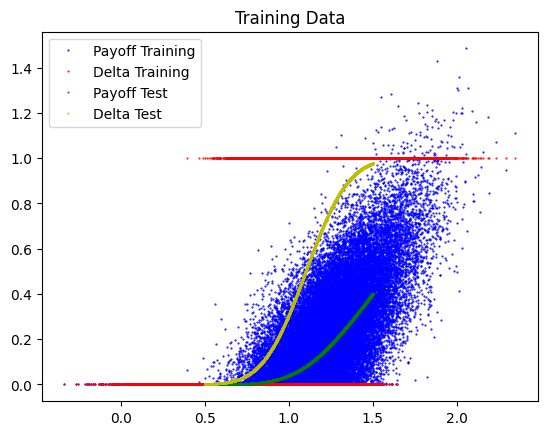

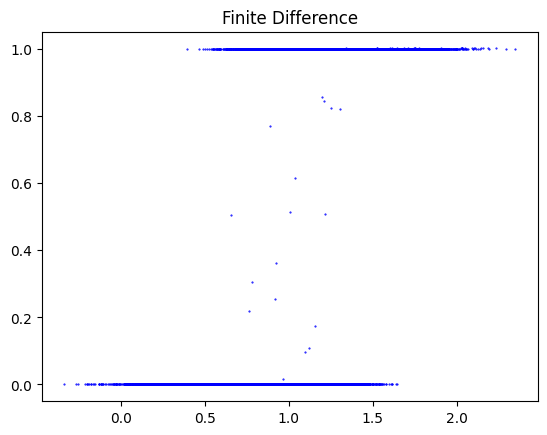

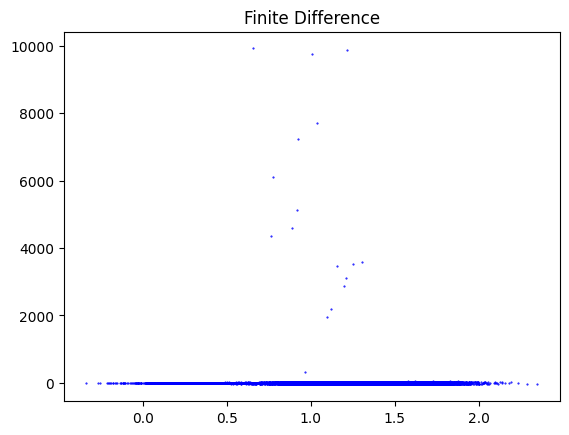

In [50]:
X, Y, Z, W, a, fd, fdd, jac_fd= trainingSet(100000, BachelierParams(),seed=42)
print(X.shape)
print(Y.shape)
print(Z.shape)
print(W.shape)
print("FD")
print(fd.shape)
print(fd)
print("JAC_FD")
print(jac_fd)


# for i, z in enumerate(Z):
#     print(i, z)
   

spots, baskets, prices, deltas, vegas = testSet(1, a, num=10000)

# plot training set:

def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, dydx_test):
    plt.title("Training Data")
    plt.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    plt.plot(x_train, dydx_train, 'r.', label='Delta Training', markersize=1)
    plt.plot(x_test, y_test, 'g.', label='Payoff Test', markersize=1)
    plt.plot(x_test, dydx_test, 'y.', label='Delta Test', markersize=1)
    plt.legend()
    plt.show()


print(spots.shape)
plot_training_data(X[:,0], Y[:,0], Z[:,0], spots[:, 0], prices[:,0], deltas[:,0])

plt.title("Finite Difference")
plt.plot(X[:,0], fd, 'b.', label='FD', markersize=1)
plt.show()

plt.title("Finite Difference")
plt.plot(X[:,0], fdd, 'b.', label='FD', markersize=1)
plt.show()
            

In [52]:
W.flatten().sum()

DeviceArray(0., dtype=float32)

In [23]:
def f(a, b):
    K = 20
    return jnp.maximum(jnp.dot(a, b) - K , 0)

# plot example evaluation of function f:

a = jnp.array([1.0, 2.0, 3.0])
b = jnp.array([4.0, 5.0, 6.0])

f(a, b)
# y, vjpfun = jax.vjp(f, a, b)  # Compute the values and obtain a VJP function
# basis = jnp.eye(y.size, dtype=y.dtype)
# jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
# print(y)
# print(jac)

DeviceArray(12., dtype=float32)